In [1]:
import pandas as pd
import numpy as np 
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.signal import lfilter, butter, welch

import os
import glob

from tqdm import tqdm_notebook

# Upload the data 

In [2]:
path = r'C:\Users\ecath\Desktop\Research\Raw Data\Ex Vivo CSV Files LD'

data_list = []
for filename in glob.glob(os.path.join(path, '*.csv')):
    data = pd.read_csv(filename, header=0)
    print(filename, data.shape)
    data_list.append(data)

C:\Users\ecath\Desktop\Research\Raw Data\Ex Vivo CSV Files LD\1.csv_annot.csv (10173, 192)
C:\Users\ecath\Desktop\Research\Raw Data\Ex Vivo CSV Files LD\10_Epi.csv_annot.csv (8191, 192)
C:\Users\ecath\Desktop\Research\Raw Data\Ex Vivo CSV Files LD\11_Endo.csv_annot.csv (10173, 192)
C:\Users\ecath\Desktop\Research\Raw Data\Ex Vivo CSV Files LD\12_Epi.csv_annot.csv (10173, 192)
C:\Users\ecath\Desktop\Research\Raw Data\Ex Vivo CSV Files LD\15_Endo.csv_annot.csv (8191, 192)
C:\Users\ecath\Desktop\Research\Raw Data\Ex Vivo CSV Files LD\16_Epi.csv_annot.csv (8191, 192)
C:\Users\ecath\Desktop\Research\Raw Data\Ex Vivo CSV Files LD\17_Endo.csv_annot.csv (10173, 192)
C:\Users\ecath\Desktop\Research\Raw Data\Ex Vivo CSV Files LD\18_Epi.csv_annot.csv (10173, 192)
C:\Users\ecath\Desktop\Research\Raw Data\Ex Vivo CSV Files LD\22.csv_annot.csv (16667, 192)
C:\Users\ecath\Desktop\Research\Raw Data\Ex Vivo CSV Files LD\23.csv_annot.csv (16383, 192)
C:\Users\ecath\Desktop\Research\Raw Data\Ex Vivo CSV 

In [3]:
len(data_list)

23

In [4]:
"""Random train/test split"""


# import random

# path = r'C:\Users\ecath\Desktop\Research\Raw Data\Ex Vivo CSV Files LD\New LD annotations\AF'
# train = r'\train'
# test = r'\test'

# if not os.path.exists(path + train):
#     os.mkdir(path + train)
    
# if not os.path.exists(path + test):
#     os.mkdir(path + test)

# train_size = 13

# random.shuffle(data_list)

# train_data = data_list[:train_size]
# test_data = data_list[train_size:]

# for i in range(len(train_data)):
#     train_data[i].to_csv(path + train + r'\train ' + str(i) + '.csv', sep = ',')
    
# for i in range(len(test_data)):
#     test_data[i].to_csv(path + test + r'\test ' + str(i) + '.csv', sep = ',')

'Random train/test split'

# Division by classes 

In [4]:
def del_empty_cols(data_list):
    for df in data_list:
        for i in df.columns:
            if i.startswith('Unnamed:_'):
                df.drop(i, inplace=True, axis=1)
                
del_empty_cols(data_list)

In [5]:
"""
Splitting spreadspeet to the classes by label 

Parameters: 
-----------
data_list: list
    List with pd.DataFrames

Returns: 
-------
drivers, nondrivers, noises: list, list, list
    Lists with pd.DataFrames, one for each of three classes respectively
"""

def class_splitting(data_list):
    
    drivers = []
    nondrivers = []
    noises = []

    for df in data_list:
        driver = pd.DataFrame()
        nondriver = pd.DataFrame()
        noise = pd.DataFrame()
        for col in df.columns[1::3]:
            curr_index = list(df.columns).index(col)
            prev_index = curr_index - 1
            next_index = curr_index + 1
            prev_col = df.iloc[:,prev_index]
            next_col = df.iloc[:,next_index]
            if df[col][0] == 1:
                driver[df.columns[prev_index]] = prev_col
                driver[df.columns[next_index]] = next_col
            elif df[col][0] == 0:
                nondriver[df.columns[prev_index]] = prev_col
                nondriver[df.columns[next_index]] = next_col
            elif df[col][0] == -1:
                noise[df.columns[prev_index]] = prev_col
                noise[df.columns[next_index]] = next_col
            else:
                noise[df.columns[prev_index]] = prev_col
                noise[df.columns[next_index]] = next_col
        drivers.append(driver)
        nondrivers.append(nondriver)
        noises.append(noise)
        
    return(drivers, nondrivers, noises)

drivers, nondrivers, noises = class_splitting(data_list)

# Butterworth bandpass [1Hz, 20Hz]

In [6]:
"""
Function performs bandpass filter for the digital signal 

Parameters: 
-----------
data: array_like
    An N-dimensional input array
lowcut: float
    Low cutoff frequency
highcut: float
    High cutoff frequency
fs: float
    Sampling rate of the signal
order: int
    The order of the filter.

Returns: 
-------
filtered_signal: array
    The output of the digital filter
"""

def butter_bandpass(data, lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    
    high = highcut / nyq
    low = lowcut / nyq
    
    b, a = butter(order, [low, high], btype='bandpass', analog=False)
    filtered_signal = lfilter(b, a, data)
    
    return filtered_signal

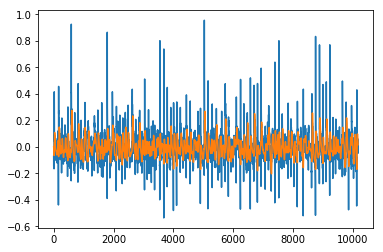

In [7]:
drivers[0][drivers[0].columns[0]].plot()
plt.plot(butter_bandpass(drivers[0][drivers[0].columns[0]], 1, 20, 1017.25))

# Fourier transform

In [8]:
"""
Fill NaN with zeros

Parameters: 
-----------
df: DataFrame
    DataFrame with NaNs
    
Returns: 
-------
df: Dataframe
    All NaNs filled by zeros
"""

def del_nul_and_nan(df):
    
    df.fillna(value=0, axis=1, inplace=True)
    
################# add to drop off zero columns ######################    
#     for col in df.columns:
#         if df[col].sum() == 0:
#             df.drop([col], axis = 1, inplace = True)  
################# add to drop off zero columns ######################    
    
    return df

In [9]:
"""


Parameters: 
-----------
df: pd.DataFrame
    An N-dimensional input DataFrame
N: int
    Number of sample points
lowcut: float
    Low cutoff frequency
highcut: float
    High cutoff frequency
fs: float
    Sampling rate of the signal

Returns: 
-------
fft_out: pd.DataFrame
    An output Dataframe with spectrum and frequencies 
"""

def spec_and_freq_for_single_df(df, N, fs, lowcut, highcut):
    
    fft_out = pd.DataFrame()
    
    for col in df.columns:
        filtered_yf = butter_bandpass(df[col], lowcut, highcut, fs, order=2)
        
        
        fft_yf = np.fft.fft(filtered_yf) #spectrum
        fft_xf = np.fft.fftfreq(N, 1/fs) #frequencies
        
        fft_20_index = np.argwhere((fft_xf<20) & (fft_xf>0))        
        fft_yf_20 = fft_yf[fft_20_index] #cutting on 20Hz
        fft_xf_20 = fft_xf[fft_20_index] #cutting on 20Hz
        
        fft_yf_20 = pd.DataFrame(np.abs(fft_yf_20) / N, columns=[col + '_yf'])
        fft_xf_20 = pd.DataFrame(fft_xf_20, columns=[col + '_xf']) 

        fft_out = pd.concat([fft_out, fft_yf_20, fft_xf_20], axis=1)
        
    return(fft_out)

In [17]:
"""


Parameters: 
-----------
df: pd.DataFrame
    An N-dimensional input DataFrame
N: int
    Number of sample points
lowcut: float
    Low cutoff frequency
highcut: float
    High cutoff frequency
fs: float
    Sampling rate of the signal

Returns: 
-------
fft_out: pd.DataFrame
    An output Dataframe with spectrum and frequencies 
"""

def spec_and_freq_for_single_df_welch(df, N, fs, lowcut, highcut):
    
    welch_out = pd.DataFrame()
    
    for col in df.columns:
        filtered_yf = butter_bandpass(df[col], lowcut, highcut, fs, order=2)
        
        welch_xf, welch_yf = welch(filtered_yf, fs=fs, nperseg=len(filtered_yf), noverlap = len(filtered_yf) / 1.5) #spectrum
        
        welch_20_index = np.argwhere((welch_xf<20) & (welch_xf>0))        
        welch_yf_20 = welch_yf[welch_20_index] #cutting on 20Hz
        welch_xf_20 = welch_xf[welch_20_index] #cutting on 20Hz
        
        welch_yf_20 = pd.DataFrame(welch_yf_20, columns=[col + '_yf'])
        welch_xf_20 = pd.DataFrame(welch_xf_20, columns=[col + '_xf']) 

        welch_out = pd.concat([welch_out, welch_yf_20, welch_xf_20], axis=1)
        
    return(welch_out)

In [18]:
"""

Parameters: 
-----------
class_data_list: list
    List with DataFrames 
    
Returns: 
-------
all_fft_el, all_fft_om: list, list
    Lists with spectrum and frequencies DataFrames
"""

def full_spec_and_freq(class_data_list, welch=False):
    
    all_fft_el = []
    all_fft_om = []

    for k, df in enumerate(class_data_list):

        electrode_signal = df[df.columns[::2]]
        optical_signal = df[df.columns[1::2]]

        electrode_signal = del_nul_and_nan(electrode_signal)
        optical_signal = del_nul_and_nan(optical_signal)        

        N = df.shape[0] # Number of sample points
        Fs_el = 1017.25 # sampling rate
        Fs_om = 1000.0
        
        if welch == True:
            fft_el = spec_and_freq_for_single_df_welch(electrode_signal, N, Fs_el, lowcut=1.5, highcut=20.0)
            fft_om = spec_and_freq_for_single_df_welch(optical_signal, N, Fs_om, lowcut=1.5, highcut=20.0)
        if welch == False: 
            fft_el = spec_and_freq_for_single_df(electrode_signal, N, Fs_el, lowcut=1.5, highcut=20.0)
            fft_om = spec_and_freq_for_single_df(optical_signal, N, Fs_om, lowcut=1.5, highcut=20.0)
            
        
        all_fft_el.append(fft_el)
        all_fft_om.append(fft_om)
        
    return(all_fft_el, all_fft_om)

In [19]:
"""

Parameters: 
-----------
class_data_list: list
    List with DataFrames 
label: int, {0,1}
    Target label
signal_type: string, {electrode, optical}
    Electrode or optical signal type
    
Returns: 
-------
all_fft: DataFrame
    Concatanation of DataFrames and adding of target value
"""

def add_target_and_concat(class_data_list, label, signal_type, welch):
    
    if signal_type == 'electrode':

        all_fft_el, _ = full_spec_and_freq(class_data_list, welch)

        m = []

        for i in range(len(all_fft_el)):
            m.append(all_fft_el[i].shape[0])

        for i in tqdm_notebook(range(len(all_fft_el))):
            mx = np.max(m) - all_fft_el[i].shape[0]

            zeros = np.zeros(shape=(mx, all_fft_el[i].shape[1]))
            zeros = pd.DataFrame(zeros, columns=all_fft_el[i].columns, index=np.arange(all_fft_el[i].shape[0], np.max(m)))

            all_fft_el[i] = all_fft_el[i].append(zeros)

            target = np.full(shape=(1, all_fft_el[i].shape[1]), fill_value = label)
            target = pd.DataFrame(target, columns=all_fft_el[i].columns, index=['target'])

            all_fft_el[i] = all_fft_el[i].append(target)

        all_fft_electrode = pd.DataFrame()

        for i in range(len(all_fft_el)):
            all_fft_electrode = pd.concat([all_fft_electrode, all_fft_el[i]], axis=1)

        return(all_fft_electrode)
    
    
    if signal_type == 'optical':
        
        _, all_fft_om = full_spec_and_freq(class_data_list, welch)

        m = []

        for i in range(len(all_fft_om)):
            m.append(all_fft_om[i].shape[0])

        for i in tqdm_notebook(range(len(all_fft_om))):
            mx = np.max(m) - all_fft_om[i].shape[0]

            zeros = np.zeros(shape=(mx, all_fft_om[i].shape[1]))
            zeros = pd.DataFrame(zeros, columns=all_fft_om[i].columns, index=np.arange(all_fft_om[i].shape[0], np.max(m)))

            all_fft_om[i] = all_fft_om[i].append(zeros)

            target = np.full(shape=(1, all_fft_om[i].shape[1]), fill_value = label)
            target = pd.DataFrame(target, columns=all_fft_om[i].columns, index=['target'])

            all_fft_om[i] = all_fft_om[i].append(target)

        all_fft_optical = pd.DataFrame()

        for i in range(len(all_fft_om)):
            all_fft_optical = pd.concat([all_fft_optical, all_fft_om[i]], axis=1)
        
        return(all_fft_optical)

# Concat dataframes with spectrum for each class and download them

In [20]:
"""
Function that save 

Parameters: 
-----------
signal_type: string, {electrode, optical}
    Electrode or optical signal type
path: string
    Path where to save file in csv format
name: string
    Name of the file
"""

def spectrum(signal_type, path, name, welch):
    
    if not os.path.exists(path):
        os.mkdir(path)

    driver_spectrum = add_target_and_concat(drivers, 1, signal_type=signal_type, welch=welch)
    nondriver_spectrum = add_target_and_concat(nondrivers, 0, signal_type=signal_type, welch=welch)

    full_spectrum = pd.concat([driver_spectrum, nondriver_spectrum], axis=1)
    full_spectrum.to_csv(path + name, sep=',', index=True)

In [ ]:
path = r'C:\Users\ecath\Desktop\Research\Raw Data\Spectrum LD Welch'
spectrum('electrode', path, '\Spectrum of electrode LD Welch.csv', welch=True)
spectrum('optical', path, '\Spectrum of optical LD Welch.csv', welch=True)

C:\Users\ecath\Anaconda3\lib\site-packages\pandas\core\frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [63]:
df = pd.read_csv(r'C:\Users\ecath\Desktop\Research\Raw Data\Spectrum LD\Spectrum of electrode LD.csv', index_col=0)

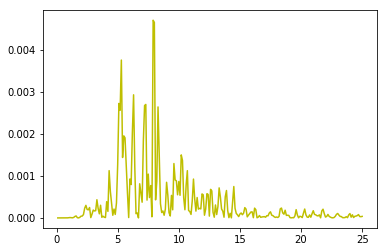

In [238]:
from scipy.signal import medfilt

ynew = medfilt(df1[df1.columns[0]])
df.drop(['target'], axis=0, inplace=True)
df1.drop(['target'], axis=0, inplace=True)
plt.plot(df[df.columns[5]], df[df.columns[4]], 'y')
# plt.plot(df1[df1.columns[1]], df1[df1.columns[0]], 'g')

# plt.plot(df1[df1.columns[1]], ynew, 'r')

# plt.xlim(0, 20)

[7.899611717290869, 5.299739506536913, 6.299690356826894, 5.099749336478915, 7.299641207116879]


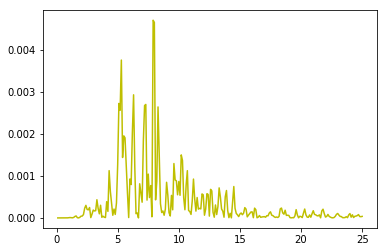

In [239]:
peaks, properties = find_peaks(df[df.columns[4]], height=0, width=0, prominence=0, rel_height=0.5)
z = np.argsort(properties['peak_heights'])
z = z[:-(5+1):-1]

frec = []
for j in range(5):
    fr = df[df.columns[5]][peaks[z][j]]
    frec.append(fr)
    
print(frec)

plt.plot(df[df.columns[5]], df[df.columns[4]], 'y')
plt.show()

[5.299739506536913, 7.899611717290869, 7.299641207116879, 7.099651037058883, 5.499729676594908]


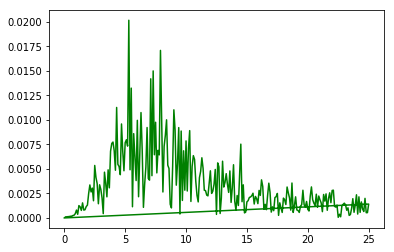

In [240]:
peaks, properties = find_peaks(df1[df1.columns[4]], height=0, width=0, prominence=0, rel_height=0.5)
z = np.argsort(properties['peak_heights'])
z = z[:-(5+1):-1]

frec = []
for j in range(5):
    fr = df1[df1.columns[5]][peaks[z][j]]
    frec.append(fr)
    
print(frec)

plt.plot(df1[df1.columns[5]], df1[df1.columns[4]], 'g')
plt.show()

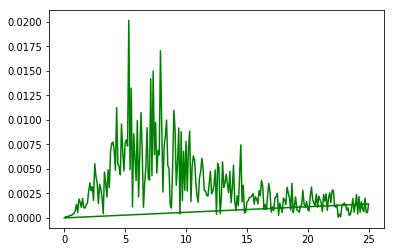

In [214]:
plt.plot(df1[df1.columns[5]], df1[df1.columns[4]], 'g')